In [1]:
! python -m spacy download en
! pip install wordcloud
! wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/sentiment.tsv?inline=false -O sentiment.tsv

     |████████████████████████████████| 12.0MB 2.3MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-cp36-none-any.whl size=12019125 sha256=df6b6fd51e61a9c8e8d67d9f6365251335b6bc5876e7bcb0eb67a156093958e8
  Stored in directory: /private/var/folders/fm/t95jwnkx3zq2j8qyfcbs32mc0000gn/T/pip-ephem-wheel-cache-vco_n3ua/wheels/48/5c/1c/15f9d02afc8221a668d2172446dd8467b20cdb9aef80a172a4
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/miklostoth/anaconda3/envs/10ai/lib/python3.6/site-packages/en_core_web_sm
-->
/Users/miklostoth/anaconda3/envs/10ai/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')
--2019-10-07 04:31:21--  https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/sentiment.tsv?inline=false
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231

# Task: sentiment classification

The task is to classify one-sentence long movie reviews/opinions according to the sentiment they express. There are only two categories: positive and negative sentiment.


> "Data source: [UMICH SI650 - Sentiment Classification](https://www.kaggle.com/c/si650winter11/data)

> Training data: 7086 lines. 
  
> Format: 1|0 (tab) sentence

> Test data: 33052 lines, each contains one sentence. 

> The data was originally collected from opinmind.com (which is no longer active)."

The data is in the file "sentiment.tsv".

# Loading the data

In [2]:
import pandas as pd

df = pd.read_csv('sentiment.tsv', sep='\t', 
                 quoting=3, # Quotes are _never_ field separators
                 header=None)

df.head()

,0,1
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


In [3]:
df = df[[1,0]] # reorder columns

df.rename(columns={1:"text", 0:"sentiment"}, inplace=True) # rename columns

df.head()

,text,sentiment
0,The Da Vinci Code book is just awesome.,1
1,this was the first clive cussler i've ever rea...,1
2,i liked the Da Vinci Code a lot.,1
3,i liked the Da Vinci Code a lot.,1
4,I liked the Da Vinci Code but it ultimatly did...,1


# Splitting into train, validation and test

Before doing anything else (!) we divide our data into train, validation and test parts,

In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test_valid = train_test_split(df, test_size = 0.2, shuffle=True, 
                                           random_state=13) # fix the seed

df_test, df_valid = train_test_split(df_test_valid, test_size = 0.5)

print(len(df_train), len(df_valid), len(df_test))

5668 709 709


# Inspecting the data

In [5]:
df_train.describe()

,sentiment
count,5668.000000
mean,0.559104
std,0.496538
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


We can examine the lengths of sentences as well.

In [6]:
n_chars = df_train.text.apply(lambda x: len(x))

n_chars.describe()

count    5668.000000
mean       60.100565
std        37.931478
min        18.000000
25%        32.000000
50%        48.000000
75%        77.000000
max       203.000000
Name: text, dtype: float64

The first sentence with the maximal length:

In [7]:
long_sentence = df_train.loc[n_chars.idxmax(), "text"]
long_sentence

'A mother in Georgia wants her local school board to take Harry Potter out of the schools and libraries because, in her opinion, reading Harry Potter leads to witchcraft, which according to her is evil...'

# Extra task: Let's do a word cloud!

Let us visualize together and separately (by category) the sentences!

Tool: https://github.com/amueller/word_cloud


Good example: https://github.com/amueller/word_cloud/blob/master/examples/simple.py



In [8]:
# Helper function for displaying a word cloud
# Input: one _UNIFIED_, space separated string!
# Protip: https://www.tutorialspoint.com/python/string_join.htm
def do_wordcloud(text):
    from wordcloud import WordCloud
    
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt

    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


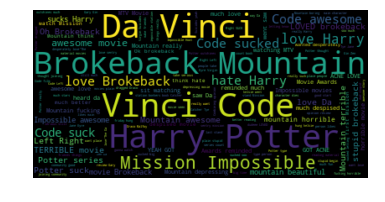

In [10]:
### TASK !!! ####
#Put here the world cloud!

do_wordcloud(' '.join(df_train["text"].values))


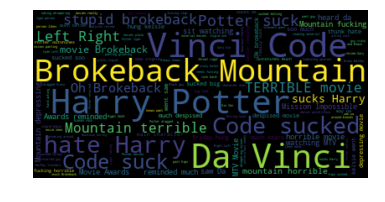

In [11]:
### TASK !!! ####
# Here only the cloud for sentences with negative sentiment!
# Help: the shape of the DataFrame with only the negative sentences is: (2975, 2)
# Source: https://pandas.pydata.org/pandas-docs/stable/indexing.html

do_wordcloud(' '.join(df_train[df_train["sentiment"]==0]["text"].values))


# Bag of words (BoW) representation of the texts

We will represent each text as a (sparse) vector of lemma (word root) counts for frequent lemmas in the training data. 

For tokenization and lemmatization we use [spaCy](https://spacy.io/), an open source Python NLP library, which can produce a list of unique lemma ids from the text.

In [12]:
import spacy

nlp = spacy.load("en", disable=["parser", "ner"]) # We need only the tokenizer

spaCy can produce spaCy Doc objects from texts that contain their linguistic analysis, among others lemmas and their unique spaCy string ids.

In [13]:
doc = nlp(long_sentence)
type(doc)

spacy.tokens.doc.Doc

In [14]:
print([token.lemma_ for token in doc ]) # Lemmas

['a', 'mother', 'in', 'Georgia', 'want', '-PRON-', 'local', 'school', 'board', 'to', 'take', 'Harry', 'Potter', 'out', 'of', 'the', 'school', 'and', 'library', 'because', ',', 'in', '-PRON-', 'opinion', ',', 'read', 'Harry', 'Potter', 'lead', 'to', 'witchcraft', ',', 'which', 'accord', 'to', '-PRON-', 'be', 'evil', '...']


In [15]:
print([token.lemma for token in doc]) # Corresponding unique ids

[11901859001352538922, 7963322251145911254, 3002984154512732771, 309210702643012516, 7597692042947428029, 561228191312463089, 16319852998319793599, 13293160603192985325, 14899812206273857344, 3791531372978436496, 6789454535283781228, 5164779919001708464, 2416965663249996073, 1696981056005371314, 886050111519832510, 7425985699627899538, 13293160603192985325, 2283656566040971221, 1785747669126016609, 16950148841647037698, 2593208677638477497, 3002984154512732771, 561228191312463089, 14536103007527724270, 2593208677638477497, 11792590063656742891, 5164779919001708464, 2416965663249996073, 82546335403996757, 3791531372978436496, 17905374590688478165, 2593208677638477497, 7063653163634019529, 701735504652304602, 3791531372978436496, 561228191312463089, 10382539506755952630, 15036397985088571056, 10875615029400813363]


Now we have to convert these lists into BoW vectors. We could "roll our own", but, fortunately, scikit-learn has a feature extractor doing exactly that, the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) so, for the sake of simplicity, we will use that along with spaCy.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer=lambda s: [token.lemma for token in nlp(s)], # use spaCy for analysis
                     min_df= 0.001) # Ignore lemmas with lower document frequency
cv

CountVectorizer(analyzer=<function <lambda> at 0xa1ecff488>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=0.001, ngram_range=(1, 1),
        preprocessor=None, stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [17]:
sents = ["I hate this movie.", "The movie is the worst I've seen."]
bows = cv.fit_transform(sents).toarray() # CountVectorizer produces a sparse matrix so we convert to ndarray
bows

array([[1, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 2, 0, 1, 1, 1, 1, 1, 1]], dtype=int64)

Using the CountVectorizer we convert the text columns of our train, validation and  test data into three sparse matrices.

In [18]:
bows_train = cv.fit_transform(df_train.text)
bows_train.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
bow_length = bows_train.shape[1]
print("BoW length:", bow_length)
bows_train

BoW length: 370


<5668x370 sparse matrix of type '<class 'numpy.int64'>'
	with 63159 stored elements in Compressed Sparse Row format>

In [26]:
print(bows_train[0,:])

  (0, 185)	1
  (0, 49)	1
  (0, 100)	1
  (0, 361)	1
  (0, 252)	1
  (0, 54)	2
  (0, 14)	1


In [19]:
bows_valid = cv.transform(df_valid.text)
bows_valid.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
bows_test = cv.transform(df_test.text)
bows_test.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement

# The model

We build a feed-forward neural network for our binary classification task, which will be trained with cross-entropy loss and minibatch SGD.

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Parameters
############

hidden_size = 100

# Model
#######

inputs = Input(shape=(bow_length,))

# Hidden layer

hidden_output = Dense(hidden_size, activation='relu')(inputs)

# Softmax 

predictions = Dense(2, activation='softmax')(hidden_output)


# Full model

model = Model(inputs=inputs, outputs=predictions)

# Optimizer
####################

optimizer = SGD(lr=0.1)
 

# Compilation and fitting 
#########################

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', # we use this cross entropy variant as the input is not 
                                                      # one-hot encoded
              metrics=['accuracy'])

# Training

In [21]:
model.fit(x=bows_train, 
          y=df_train.sentiment.values,
          validation_data=(bows_valid, df_valid.sentiment.values),
          epochs=10,
          batch_size=200)

Train on 5668 samples, validate on 709 samples
Epoch 1/10
5668/5668 [==============================] - 0s 43us/step - loss: 0.5316 - acc: 0.7946 - val_loss: 0.4029 - val_acc: 0.9182
Epoch 2/10
5668/5668 [==============================] - 0s 13us/step - loss: 0.3234 - acc: 0.9432 - val_loss: 0.2568 - val_acc: 0.9464
Epoch 3/10
5668/5668 [==============================] - 0s 12us/step - loss: 0.2067 - acc: 0.9619 - val_loss: 0.1775 - val_acc: 0.9478
Epoch 4/10
5668/5668 [==============================] - 0s 11us/step - loss: 0.1473 - acc: 0.9651 - val_loss: 0.1353 - val_acc: 0.9535
Epoch 5/10
5668/5668 [==============================] - 0s 11us/step - loss: 0.1142 - acc: 0.9735 - val_loss: 0.1069 - val_acc: 0.9704
Epoch 6/10
5668/5668 [==============================] - 0s 10us/step - loss: 0.0940 - acc: 0.9787 - val_loss: 0.0889 - val_acc: 0.9760
Epoch 7/10
5668/5668 [==============================] - 0s 11us/step - loss: 0.0800 - acc: 0.9813 - val_loss: 0.0769 - val_acc: 0.9817
Epoch 8/

# Prediction

In [27]:
print("=== INTERACTIVE DEMO ===")
while True:
    s = input("Enter a short text to evaluate or press return to quit: ")
    if s == "":
        break
    else:
        bow = cv.transform([s])
        prob_pred = model.predict(bow[0])
        print(f"Positive vs negative sentiment probability: {prob_pred[0,1]} vs {prob_pred[0,0]}")

=== INTERACTIVE DEMO ===
Enter a short text to evaluate or press return to quit: 
